# scikit learn models

In [1]:
# import libraries
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz, plot_tree
import matplotlib.pyplot as plt
import pydotplus

# assign a path for data files
DATA_DIR  = "../../data/processed/"
GRAPH_DIR = "../../results/"

# change the font
plt.rcParams["font.family"] = "serif"

## Dimension reduction and loading data

From the poll data, we now have a robust threshold of narrowing down the tossup states, which will be our target of classification for this assignment

In [2]:
# import the poll classification data
df_target_states_class = pd.read_csv(f"{DATA_DIR}2020_polls_classification.csv", index_col="state")

# get the states where its classified as 'tossup'
tossup_state = list(df_target_states_class.loc[df_target_states_class['classification']=="tossup"].index)

# print the target state that we will predict
print(tossup_state)

['AZ', 'FL', 'GA', 'IA', 'MI', 'MN', 'MO', 'MT', 'NV', 'NH', 'NM', 'NC', 'OH', 'PA', 'TX', 'WI']


In [3]:
# import data and standardize the index to "state"
## Label data
df_result = pd.read_csv(f"{DATA_DIR}2020_presidential_election.csv", index_col="state")

## Predictor
### household income data
df_income = pd.read_csv(f"{DATA_DIR}household_income.csv")
df_income.rename(columns={"Unnamed: 0":"state"}, inplace=True)
df_income.set_index('state', inplace=True)

### education data
df_education = pd.read_csv(f"{DATA_DIR}education.csv")
df_education.rename(columns={"Unnamed: 0":"state"}, inplace=True)
df_education.set_index('state', inplace=True)

### populaton density data
df_popdensity = pd.read_csv(f"{DATA_DIR}pop_density.csv")
df_popdensity.rename(columns={"STUSPS":"state"}, inplace=True)
df_popdensity.set_index('state', inplace=True)
df_popdensity.drop(index='PR', inplace=True)

### unemployment rate data
df_unemployment = pd.read_csv(f"{DATA_DIR}unemployment_rate.csv")
df_unemployment.rename(columns={"state":"state_full", "code":"state"}, inplace=True)
df_unemployment.set_index('state', inplace=True)

### race data
df_race = pd.read_csv(f"{DATA_DIR}race_percentage_2015_2019.csv")
df_race.rename(columns={"STUSPS":"state"}, inplace=True)
df_race.set_index('state', inplace=True)
df_race.drop(index='PR', inplace=True)

### Life expectancy
df_life_exp = pd.read_csv(f"{DATA_DIR}life_expectancy.csv", index_col="state")

### polling data
df_poll = pd.read_csv(f"{DATA_DIR}2020_adjusted_polls_and_results.csv", index_col="state")

In [4]:
# modify the variables to limit eplanatory variables
## education data
df_education_m = df_education.loc[:, ["PercentHighSchoolOrHigher", "PercentBachelorsOrHigher"]]

## income data
df_income_m = df_income.loc[:, ["real_per_capita_personal_income", "RPPs"]]
df_income_m["income_per_RPPs"] = df_income_m["real_per_capita_personal_income"] / df_income_m['RPPs']

## population density data
df_popdensity_m = df_popdensity.loc[:, "B01001_calc_PopDensity"]

## unemployment rate data
df_unemployment_m = df_unemployment.loc[:, "rate"]

## race ratio data
df_race_m = df_race.iloc[:, 2:]

# setting the label data
df_result_m = df_result.loc[:, "winner"]

## VIF testing function (Checking for Heteroskedasticity)

In [5]:
# make a function that checks for multicollinearity within the columns using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

# Define the VIF generator from a given explanatory variable 
def VIF_operator(exp_var_df):
  vif_data = pd.DataFrame()
  vif_data["feature"], vif_data["VIF"] = exp_var_df.columns, [VIF(exp_var_df.values, i) for i in range(len(exp_var_df.columns))]
  res = []
  for i in range(len(vif_data)):
    if vif_data["VIF"][i] > 10:
      res.append("High Correlation")
    else:
      res.append("Pass")
  vif_data["Result"] = res
  vif_data = vif_data.set_index("feature")
  return vif_data

## checking for multicollinearity within the variables that we use
Within the variables, we want to avoid multicollinearity so we will check using statistical value VIF and drop the vif value under 10 to maintain heteroskedasticity

In [6]:
display(VIF_operator(df_education_m))
display(VIF_operator(df_income_m))
display(VIF_operator(df_race_m))

,VIF,Result
feature,,
PercentHighSchoolOrHigher,29.440133,High Correlation
PercentBachelorsOrHigher,29.440133,High Correlation


,VIF,Result
feature,,
real_per_capita_personal_income,359.935906,High Correlation
RPPs,129.583703,High Correlation
income_per_RPPs,208.978131,High Correlation


,VIF,Result
feature,,
white_percentage,10.954882,High Correlation
hispanic_percentage,3.201402,Pass
multiple_race_percentage,25.405264,High Correlation
black_percentage,3.635500,Pass
american_indian_percentage,3.645624,Pass
asian_percentage,16.040863,High Correlation
native_hawaiian_percentage,14.061851,High Correlation
other_race_percentage,4.804481,Pass
multiple_race_exclude_latino_percentage,30.526323,High Correlation


In [7]:
# we will drop columns within our variables that shows high correlation
## Education variable: drop high school percent
df_education_m.drop(columns=["PercentHighSchoolOrHigher"], inplace=True)

## Income variable: drop personal income per capita and RPPs (income_per_RPPs is a standardized income index taking into account the regional price differences)
df_income_m.drop(columns=["real_per_capita_personal_income", "RPPs"], inplace=True)

## Race variable: drop white percentage, asian percentage, multiple race percentages (exclude latino, and normal)
df_race_m.drop(columns=["multiple_race_percentage", "multiple_race_exclude_latino_percentage", "native_hawaiian_percentage"], inplace=True)

In [8]:
# getting the temporary explanatory data concatted
df_exp_temp = pd.concat([df_education_m, df_income_m, df_popdensity_m, df_unemployment_m, df_race_m], axis=1)

# Supervised Machine Learning Modelling
Our objective is to obtain the result of the 16 tossup states, so we allocate the 35 non-tossup states to training dataset, and 16 tossup states to test dataset

In [9]:
# make a function that models the data and outputs the accuracy results
def scikit_learn_accuracy_comparison(df, tossup, graph_name, show=False, graph=False):
    # get the indecies which goes into the training dataset (non-tossup states)
    non_tossup = list(x for x in list(df.index) if x not in tossup)

    df_test  = df.loc[df.index.isin(tossup)]
    df_train = df.loc[df.index.isin(non_tossup)]
    # manually train_test split based on tossup states
    X_train, X_test = np.array(df_train.iloc[:, :-1]), np.array(df_test.iloc[:, :-1])
    y_train, y_test = np.array(df_train.iloc[:,  -1]), np.array(df_test.iloc[:,  -1])

    # normalize the explanatory variable with MinMaxScaler
    scaler  = MinMaxScaler()
    X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

    # assign models
    LR_clf  = LogisticRegression()
    NB_clf  = GaussianNB()
    GB_clf  = GradientBoostingClassifier(max_depth=4, max_features='auto')

    # fit models
    LR_clf.fit(X_train, y_train)
    NB_clf.fit(X_train, y_train)
    GB_clf.fit(X_train, y_train)

    # make predictions
    LR_predict  = LR_clf.predict(X_test)
    NB_predict  = NB_clf.predict(X_test)
    GB_predict  = GB_clf.predict(X_test)

    # get accuracy scores
    LR_accuracy  = accuracy_score(y_test, LR_predict)
    NB_accuracy  = accuracy_score(y_test, NB_predict)
    GB_accuracy  = accuracy_score(y_test, GB_predict)

    # get dataframe of results
    label   = list(df_test.index)
    results = pd.DataFrame({'Actual': y_test, 'Logistic Regression': LR_predict, 
                                'Naive Bayes': NB_predict, "GDBT": GB_predict}, index=label)
    results.loc["summary"] = {"Actual": np.nan, 'Logistic Regression': LR_accuracy, 
                                "Naive Bayes": NB_accuracy, "GDBT": GB_accuracy}
    if show == True:
        # display
        display(results)

    # plotting the deision tree 
    plt.figure(figsize=(15, 10))
    plt_tree = plot_tree(GB_clf.estimators_[0][0], feature_names=list(df.columns[:-1]), filled=True)
    plt.title(f'{graph_name} Gradient Boost Decision Tree Plot')
    graph_png_name = graph_name.replace(" ", "_")
    plt.savefig(f'{GRAPH_DIR}/{graph_png_name}_GBDT.png')

    if graph == True:
        plt.show()
    
    return results

## adjusted polling data

### Checking for Multicollinearity

In [10]:
# get the adjusted polling data
df_poll_adj = df_poll.loc[:, ["2020_polls_adjusted"]]

# concat the adjusted polling data into the temporary explanatory dataframe
df_adjusted_exp = pd.concat([df_exp_temp, df_poll_adj], axis=1)

In [11]:
# Run the function for explanatory variable dataframe
initial_vif = VIF_operator(df_adjusted_exp)
display(initial_vif)

,VIF,Result
feature,,
PercentBachelorsOrHigher,191.606894,High Correlation
income_per_RPPs,303.524301,High Correlation
B01001_calc_PopDensity,3.208322,Pass
rate,43.582138,High Correlation
white_percentage,210.078275,High Correlation
hispanic_percentage,10.150996,High Correlation
black_percentage,9.532686,Pass
american_indian_percentage,2.430688,Pass
asian_percentage,5.424155,Pass


In [12]:
# we see high correlation between education and unemployment rate variable
# therefore, we need to delete either the education column or the income variable since they are too correlated for being modeled together
# we will drop education variable here
df_adjusted_exp_w_income = df_adjusted_exp.drop(columns=["PercentBachelorsOrHigher", "rate",  "white_percentage"], inplace=False)
vif_w_income = VIF_operator(df_adjusted_exp_w_income)
display(vif_w_income)

# we will make a split table not having the income level variable
df_adjusted_exp_w_education = df_adjusted_exp.drop(columns=["income_per_RPPs", "rate", "white_percentage"], inplace=False)
vif_w_education = VIF_operator(df_adjusted_exp_w_education)
display(vif_w_education)

# we will make a split table not having the income level variable
df_adjusted_exp_w_labour = df_adjusted_exp.drop(columns=["PercentBachelorsOrHigher", "income_per_RPPs", "white_percentage"], inplace=False)
vif_w_labour = VIF_operator(df_adjusted_exp_w_labour)
display(vif_w_labour)

,VIF,Result
feature,,
income_per_RPPs,6.422285,Pass
B01001_calc_PopDensity,2.204905,Pass
hispanic_percentage,2.794726,Pass
black_percentage,3.106043,Pass
american_indian_percentage,1.614231,Pass
asian_percentage,2.148622,Pass
other_race_percentage,4.866115,Pass
2020_polls_adjusted,2.637751,Pass


,VIF,Result
feature,,
PercentBachelorsOrHigher,6.749772,Pass
B01001_calc_PopDensity,2.225864,Pass
hispanic_percentage,2.806231,Pass
black_percentage,3.048188,Pass
american_indian_percentage,1.601523,Pass
asian_percentage,2.161920,Pass
other_race_percentage,4.851480,Pass
2020_polls_adjusted,2.338526,Pass


,VIF,Result
feature,,
B01001_calc_PopDensity,2.198970,Pass
rate,7.731754,Pass
hispanic_percentage,3.126341,Pass
black_percentage,3.507268,Pass
american_indian_percentage,1.642030,Pass
asian_percentage,2.181310,Pass
other_race_percentage,4.434051,Pass
2020_polls_adjusted,2.409033,Pass


### Modelling

,Actual,Logistic Regression,Naive Bayes,GDBT
MT,R,R,R,R
MN,D,R,R,D
NH,D,R,R,D
WI,D,R,R,D
IA,R,R,R,R
MI,D,R,D,D
PA,D,R,D,D
OH,R,R,D,R
MO,R,R,R,R
FL,R,D,D,D


,Actual,Logistic Regression,Naive Bayes,GDBT
MT,R,R,R,R
MN,D,R,D,D
NH,D,R,D,D
WI,D,R,R,D
IA,R,R,R,R
MI,D,R,R,D
PA,D,R,D,D
OH,R,R,R,R
MO,R,R,R,R
FL,R,D,D,D


,Actual,Logistic Regression,Naive Bayes,GDBT
MT,R,R,R,R
MN,D,R,R,D
NH,D,R,R,D
WI,D,R,R,D
IA,R,R,R,R
MI,D,D,D,D
PA,D,D,D,D
OH,R,R,D,R
MO,R,R,R,R
FL,R,D,D,D


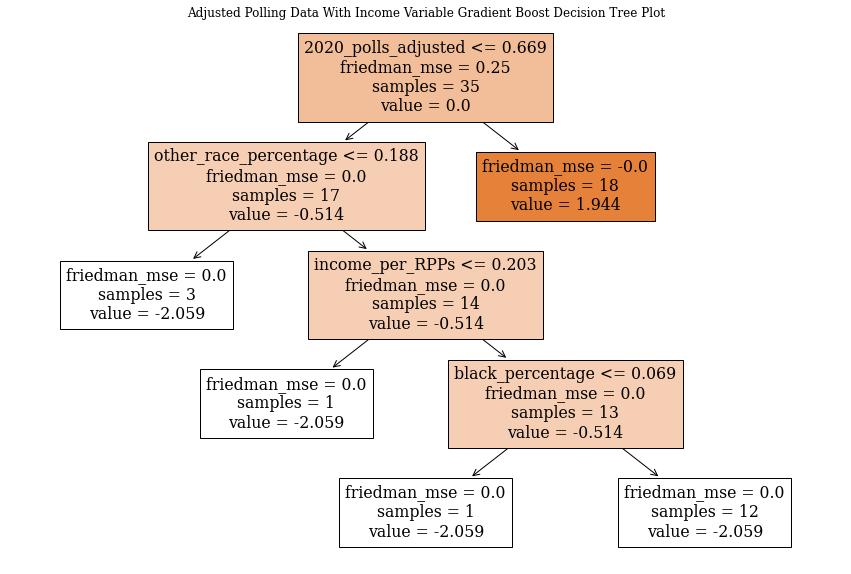

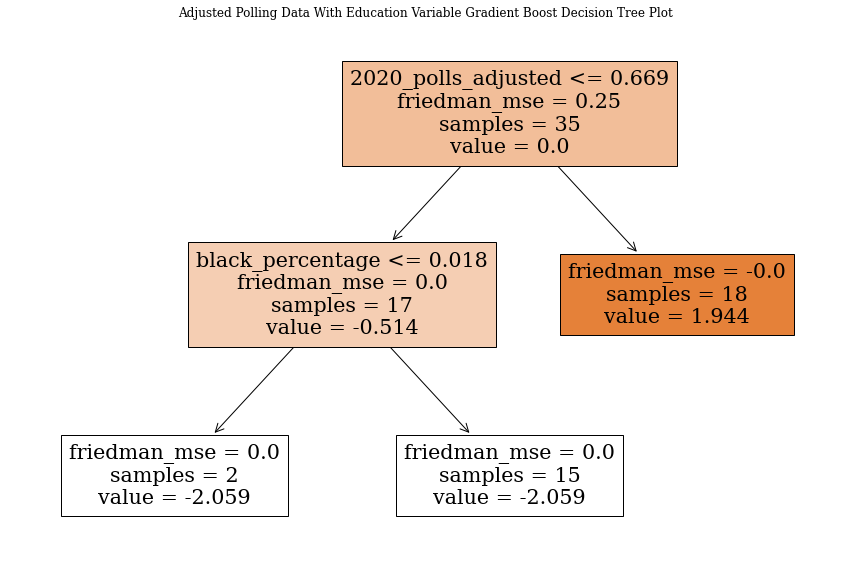

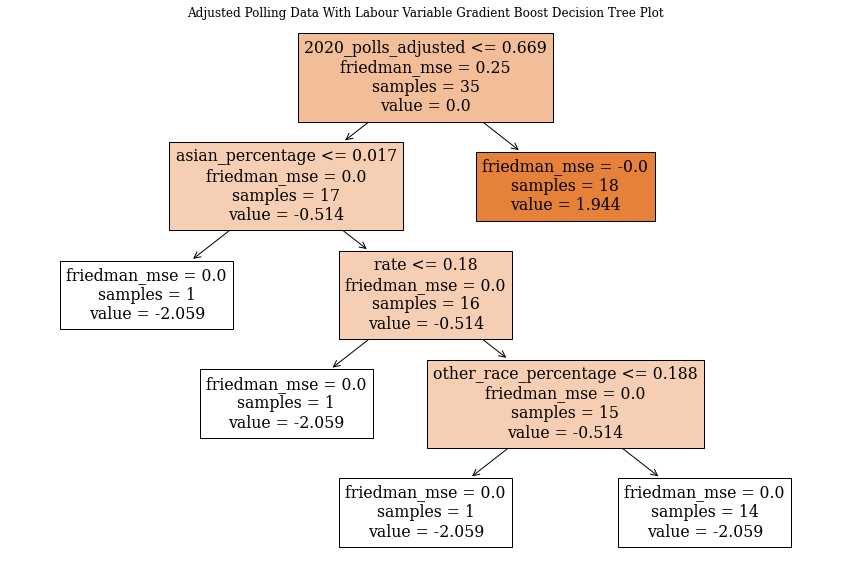

In [13]:
# add the label data at the end
df_adjusted_w_income    = pd.concat([df_adjusted_exp_w_income, df_result_m], axis=1)
df_adjusted_w_education = pd.concat([df_adjusted_exp_w_education, df_result_m], axis=1)
df_adjusted_w_labour    = pd.concat([df_adjusted_exp_w_labour, df_result_m], axis=1)

# get the results for both our explanatory variables
adjusted_w_income_res    = scikit_learn_accuracy_comparison(df_adjusted_w_income, tossup_state, "Adjusted Polling Data With Income Variable", True)
adjusted_w_education_res = scikit_learn_accuracy_comparison(df_adjusted_w_education, tossup_state, "Adjusted Polling Data With Education Variable", True)
adjusted_w_labour_res    = scikit_learn_accuracy_comparison(df_adjusted_w_labour, tossup_state, "Adjusted Polling Data With Labour Variable", True)

## un-adjusted polling data

### tidy the dataframe format

In [14]:
# un-adjusted polling data
df_poll_raw = df_poll.loc[:, ["2020_polls_margin"]]

# we use the same variable as the previous model without the adjusted polling data (to ensure heteroskedasticity)
df_raw_exp_w_income = df_adjusted_exp_w_income.drop(columns=["2020_polls_adjusted"])
df_raw_exp_w_education    = df_adjusted_exp_w_education.drop(columns=["2020_polls_adjusted"])
df_raw_exp_w_labour = df_adjusted_exp_w_labour.drop(columns=["2020_polls_adjusted"])

# concat the raw polling data and the label data for final dataframe
df_raw_w_income = pd.concat([df_raw_exp_w_income, df_poll_raw, df_result_m], axis=1)
df_raw_w_education = pd.concat([df_raw_exp_w_education, df_poll_raw, df_result_m], axis=1)
df_raw_w_labour = pd.concat([df_raw_exp_w_labour, df_poll_raw, df_result_m], axis=1)

### modelling

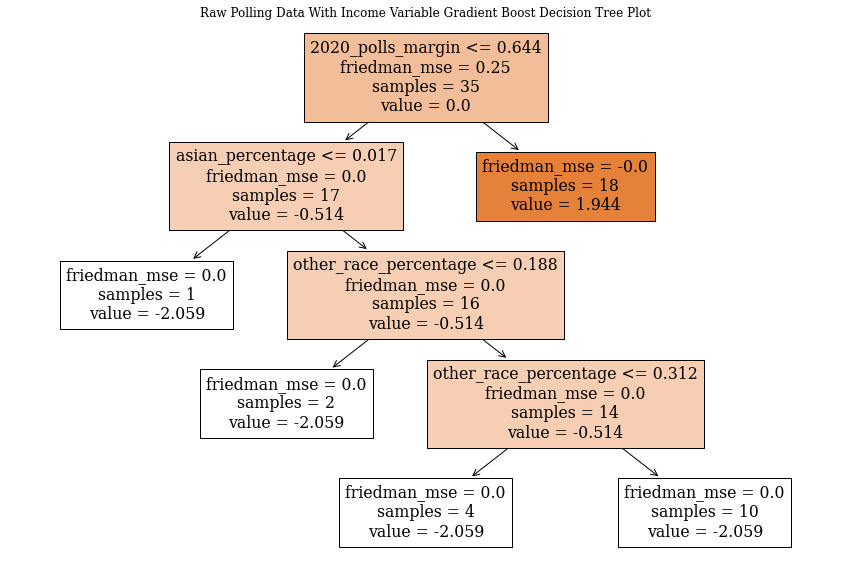

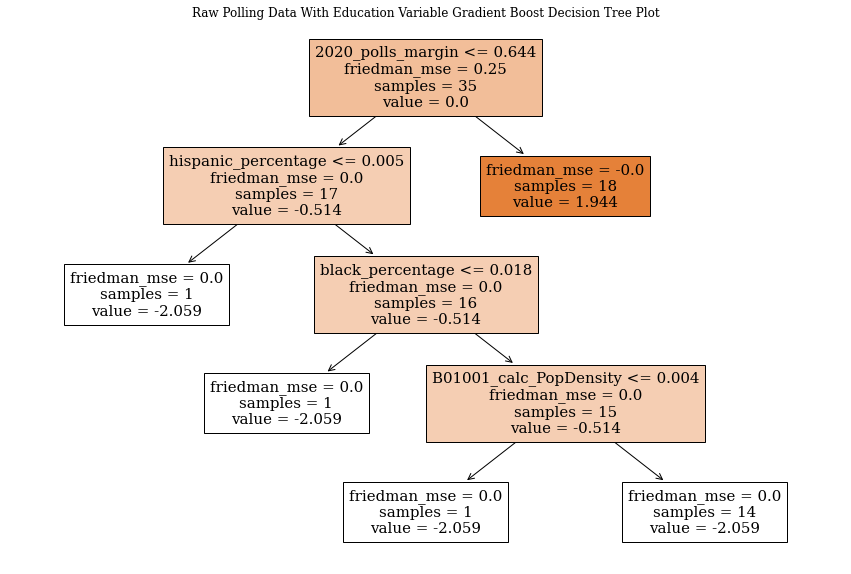

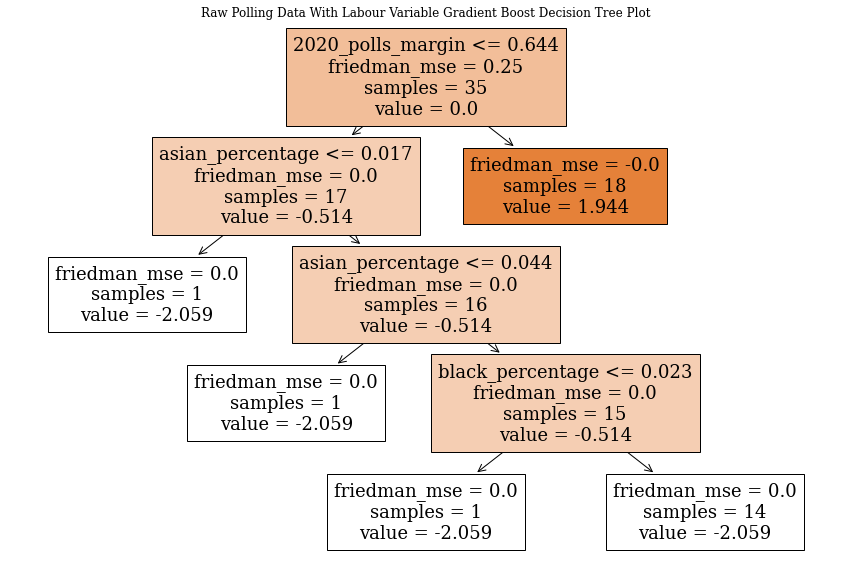

In [15]:
# get the results for both our explanatory variables
raw_w_income_res    = scikit_learn_accuracy_comparison(df_raw_w_income, tossup_state, "Raw Polling Data With Income Variable")
raw_w_education_res = scikit_learn_accuracy_comparison(df_raw_w_education, tossup_state, "Raw Polling Data With Education Variable")
raw_w_labour_res    = scikit_learn_accuracy_comparison(df_raw_w_labour, tossup_state, "Raw Polling Data With Labour Variable")

## without polling data

In [16]:
# Use the data used in the previous model without the polling data (to ensure heteroskedasticity)
df_wo_polls_w_income    = df_raw_w_income.drop(columns=["2020_polls_margin"], inplace=False)
df_wo_polls_w_education = df_raw_w_education.drop(columns=["2020_polls_margin"], inplace=False)
df_wo_polls_w_labour    = df_raw_w_labour.drop(columns=["2020_polls_margin"], inplace=False)

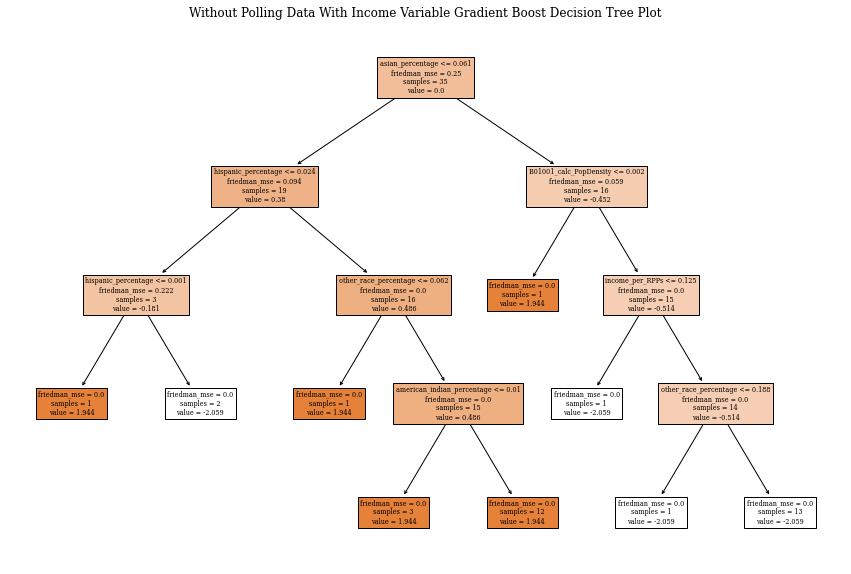

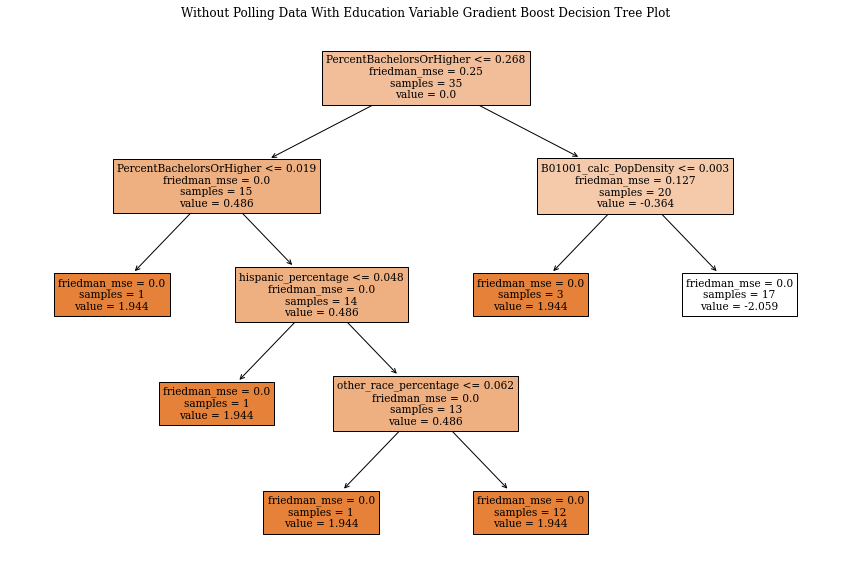

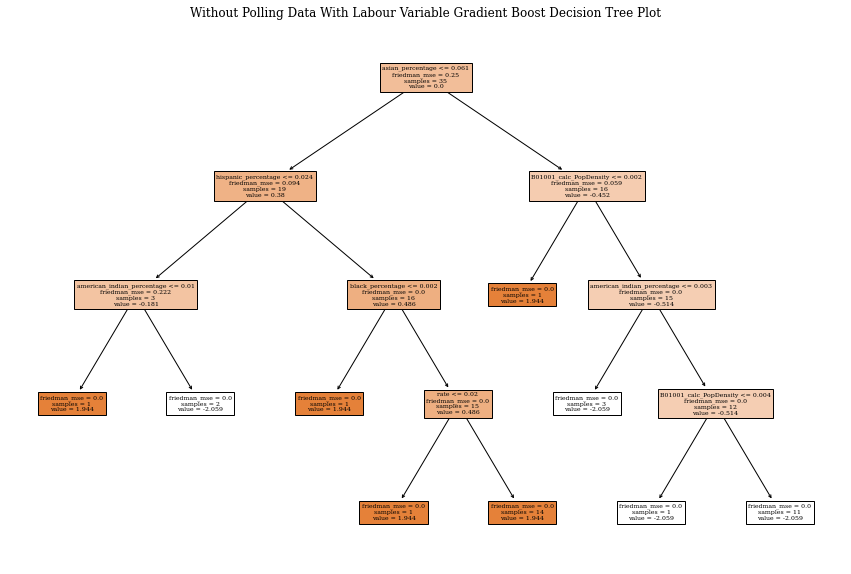

In [17]:
without_polls_w_income_res    = scikit_learn_accuracy_comparison(df_wo_polls_w_income, tossup_state, "Without Polling Data With Income Variable")
without_polls_w_education_res = scikit_learn_accuracy_comparison(df_wo_polls_w_education, tossup_state, "Without Polling Data With Education Variable")
without_polls_w_labour_res    = scikit_learn_accuracy_comparison(df_wo_polls_w_labour, tossup_state, "Without Polling Data With Labour Variable")


## polling data and one more variable

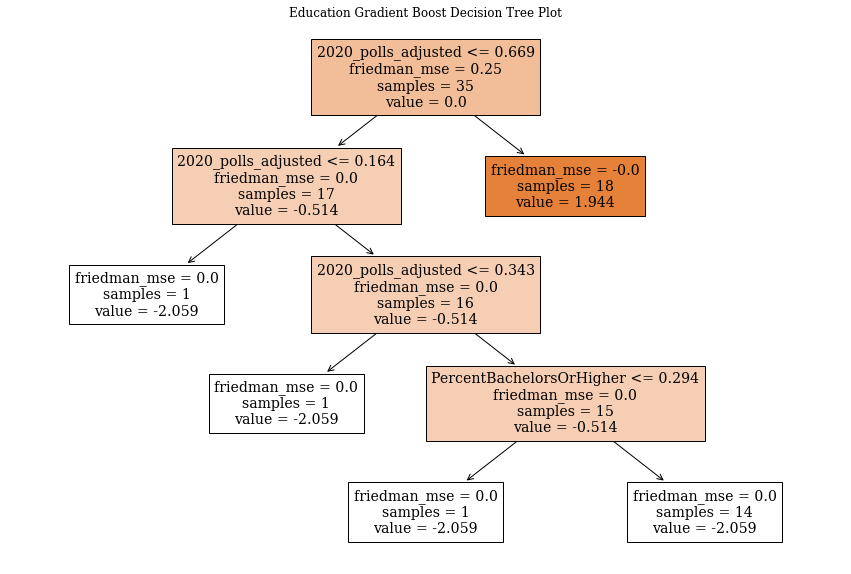

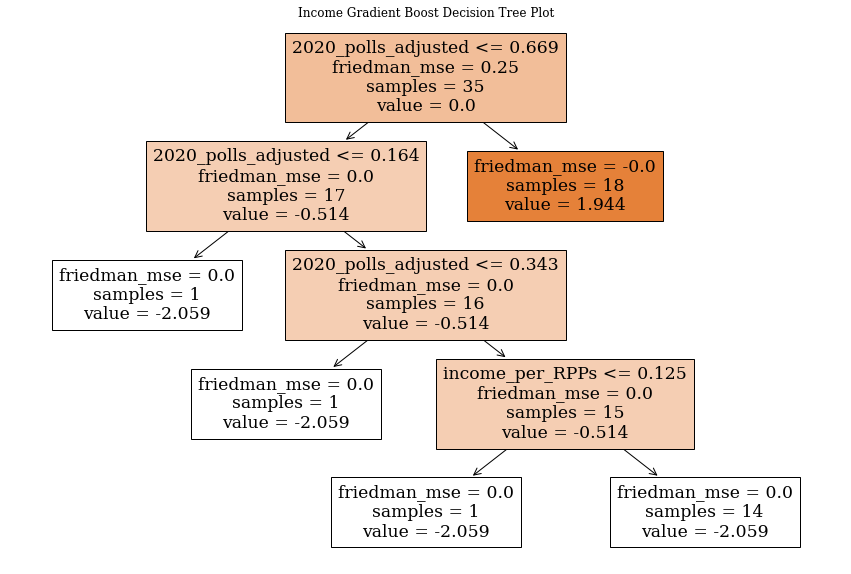

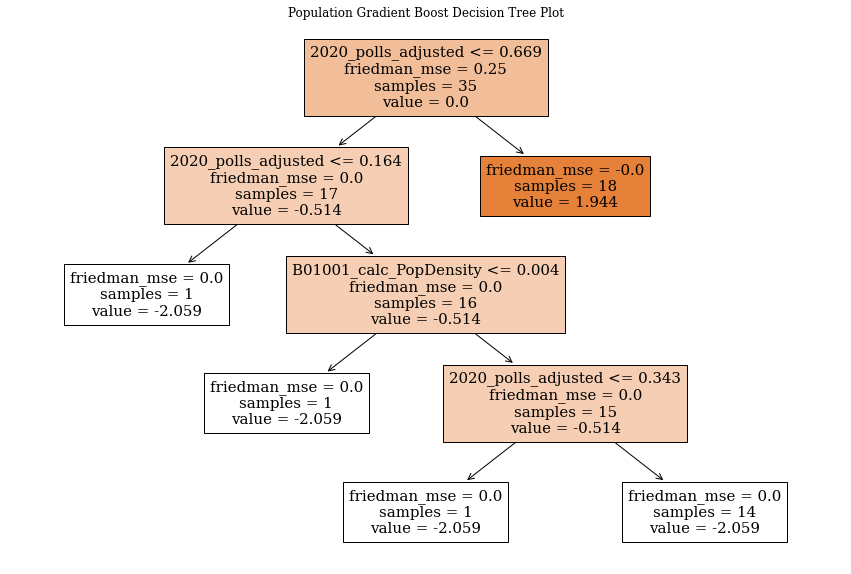

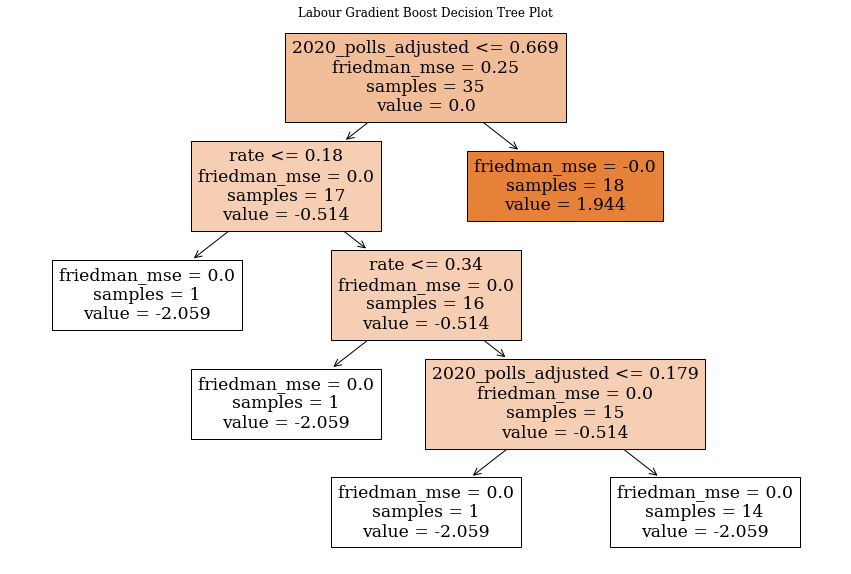

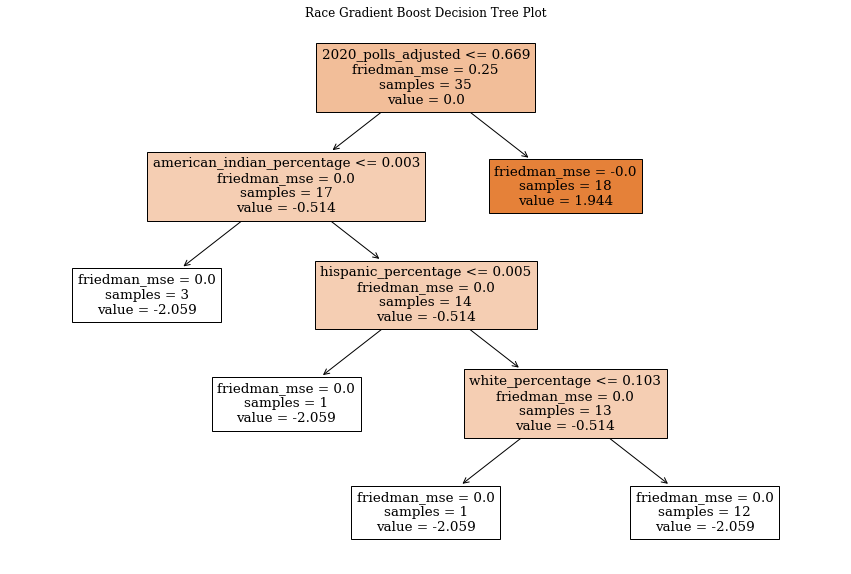

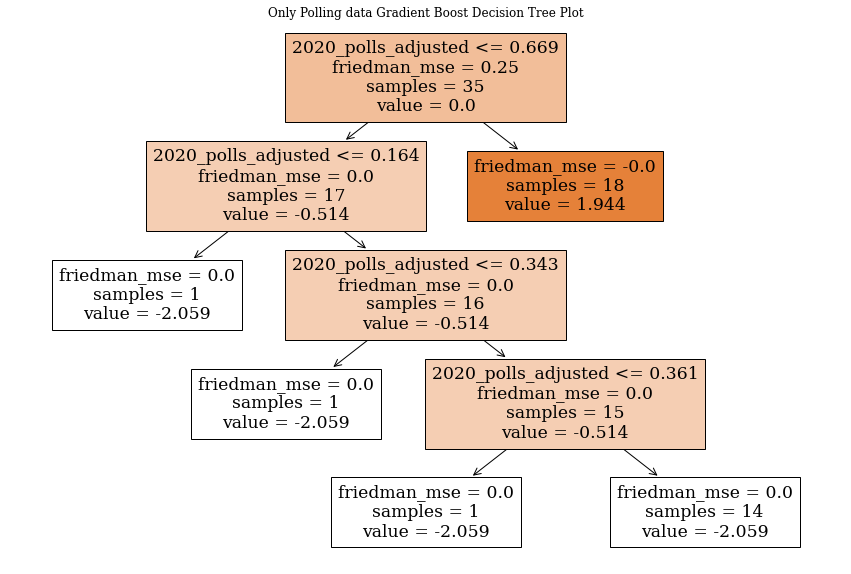

In [18]:
# loop for feature and store the results to a single list
feature = ['Education', 'Income', 'Population', 'Labour', 'Race', 'Only Polling data']
feature_df = [df_education_m, df_income_m, df_popdensity_m, df_unemployment_m, df_race_m]

# get the adjusted polling data
df_poll_m = df_poll.loc[:, ["2020_polls_adjusted"]]

results_list = []
for i in range(len(feature_df)+1):
    pred_explanatory = [df_poll_m]

    if i < len(feature_df):
        pred_explanatory.append(feature_df[i])  
    
    pred_explanatory.append(df_result_m)
    pred_explanatory = pd.concat(pred_explanatory, axis=1)
    df_res = scikit_learn_accuracy_comparison(pred_explanatory, tossup_state, feature[i])
    results_list.append(df_res)

## data visualisations


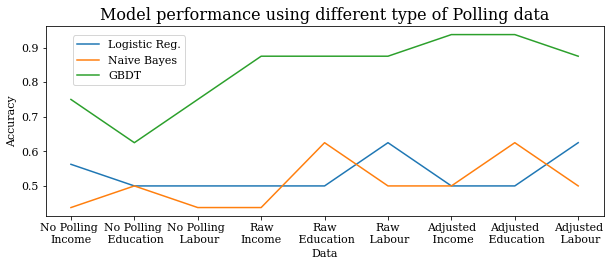

In [55]:
# Model accuracy using different type of polling data
data = ["No Polling \nIncome", "No Polling \n Education", "No Polling \n Labour", 
        "Raw\nIncome", "Raw\n Education", "Raw\n Labour",
        "Adjusted\n Income", "Adjusted\n Education", "Adjusted\n Labour"]
res_list = [without_polls_w_income_res, without_polls_w_education_res, without_polls_w_labour_res, 
            raw_w_income_res, raw_w_education_res, raw_w_labour_res, 
            adjusted_w_income_res, adjusted_w_education_res, raw_w_labour_res]
logistic_regression, naive_bayes, support_vector_machine, gbdt = [], [], [], []
# get the results from loop
for i in range(len(res_list)):
    logistic_regression.append(res_list[i].iloc[-1, 1])
    naive_bayes.append(res_list[i].iloc[-1, 2])
    gbdt.append(res_list[i].iloc[-1, 3])

plt.figure(figsize=(10, 3.5))
plt.plot(data, logistic_regression, label='Logistic Reg.')
plt.plot(data, naive_bayes, label='Naive Bayes')
plt.plot(data, gbdt, label='GBDT')
plt.title('Model performance using different type of Polling data', fontsize=16)
plt.legend(bbox_to_anchor=(0.25, 0.95), borderaxespad=0., fontsize=11)
plt.xlabel('Data', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=11)

# Save the figure
plt.savefig(f"{GRAPH_DIR}model_performance_for_pollingdata.png")

# Show the plot
plt.show()

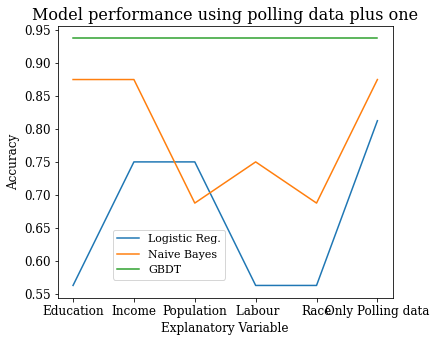

In [50]:
# Model accuracy with adjusted polling data while adding 1 additional different explanatory variable
var = ['Education', 'Income', 'Population', ' Labour', 'Race', 'Only Polling data']
logistic_regression, naive_bayes, gbdt = [], [], []
# get the results from loop
for i in range(len(results_list)):
    logistic_regression.append(results_list[i].iloc[-1, 1])
    naive_bayes.append(results_list[i].iloc[-1, 2])
    gbdt.append(results_list[i].iloc[-1, 3])

# Set the figure size
plt.figure(figsize=(6, 5))

# Plot the data
plt.plot(var, logistic_regression, label='Logistic Reg.')
plt.plot(var, naive_bayes, label='Naive Bayes')
plt.plot(var, gbdt, label='GBDT')
plt.title('Model performance using polling data plus one', fontsize=16)
plt.legend(bbox_to_anchor=(0.5, 0.25), borderaxespad=0., fontsize=11)
plt.xlabel('Explanatory Variable', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the figure
plt.savefig(f"{GRAPH_DIR}adjpolling_data_with_one_more_variable.png")

# show the figure
plt.show()

## 2016 Election prediction

In [52]:
tossup_2016 = pd.read_csv(f"{DATA_DIR}2016_polls_classification.csv")
tossup_state_2016 = list(tossup_2016.loc[tossup_2016["classification"]=="tossup", "state"])

election_2012 = pd.read_csv(f"{DATA_DIR}2012_presidential_election.csv", index_col="state")

## polling data
df_polls_2016 = pd.read_csv(f"{DATA_DIR}2016_adjusted_polls_and_results.csv", index_col="state")
df_polls_2016_adj = df_polls_2016.loc[:, ["2016_polls_adjusted"]]
## replace NA values with 2012 election data
for i in df_polls_2016_adj[df_polls_2016_adj['2016_polls_adjusted'].isnull()].index:
    df_polls_2016_adj.loc[i, "2016_polls_adjusted"] = election_2012.loc[i, "2012_results_margin"]

## the outcome data
df_resuls_2016 = pd.read_csv(f"{DATA_DIR}2016_presidential_election.csv").loc[:, "winner"]
df_adjusted_exp_2016 = pd.concat([df_exp_temp, df_polls_2016_adj], axis=1)

,Actual,Logistic Regression,Naive Bayes,SVM,GDBT
MN,D,R,D,D,D
NH,D,R,R,D,D
ME,D,R,R,D,D
AK,R,R,D,D,R
UT,R,D,R,R,R
IA,R,R,R,D,D
CO,D,D,D,D,D
KS,R,R,R,R,R
MI,D,D,D,D,D
OR,D,D,D,D,D


,Actual,Logistic Regression,Naive Bayes,SVM,GDBT
MN,D,D,D,D,D
NH,D,D,D,D,D
ME,D,R,R,D,D
AK,R,R,D,R,R
UT,R,D,R,R,R
IA,R,R,R,R,D
CO,D,D,D,D,D
KS,R,R,R,R,R
MI,D,R,D,D,D
OR,D,D,D,D,D


,Actual,Logistic Regression,Naive Bayes,SVM,GDBT
MN,D,R,D,R,D
NH,D,R,R,R,D
ME,D,R,R,R,D
AK,R,R,D,D,R
UT,R,R,R,R,R
IA,R,R,R,R,D
CO,D,D,D,D,D
KS,R,R,R,R,R
MI,D,D,D,D,D
OR,D,D,D,D,D


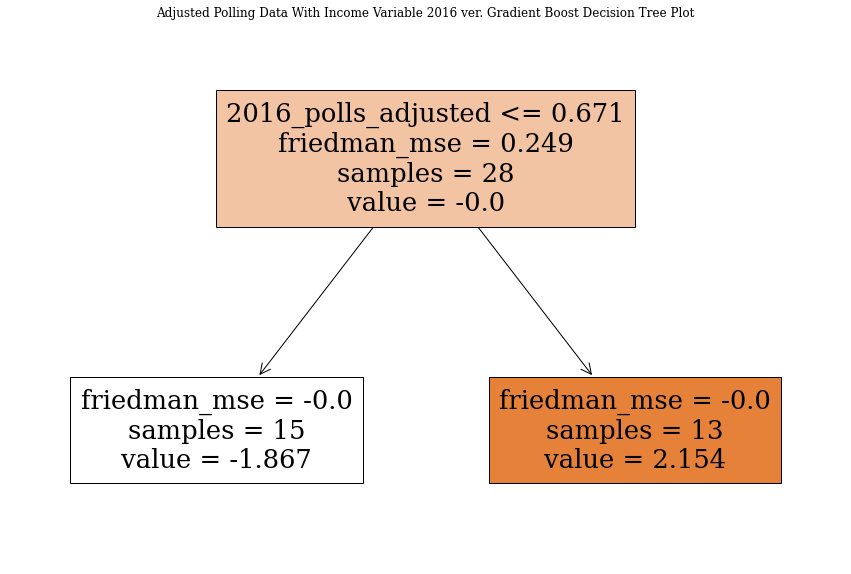

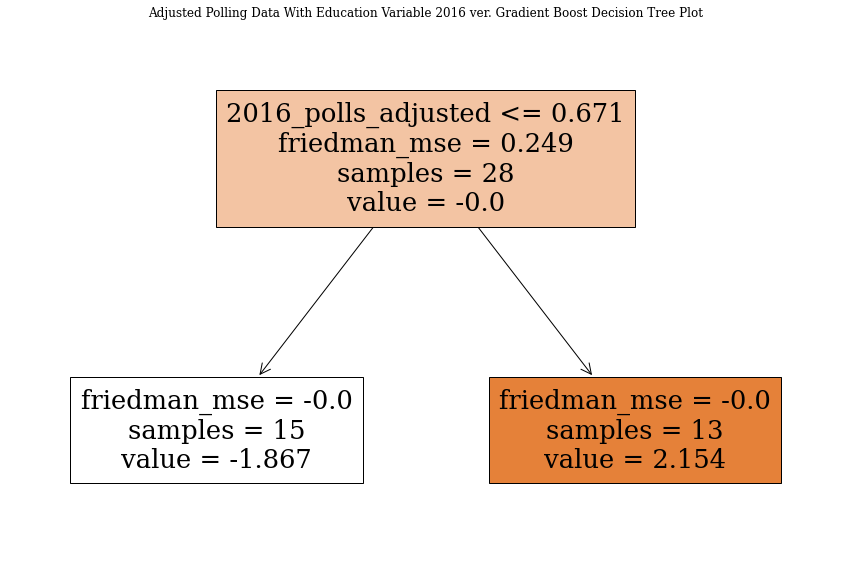

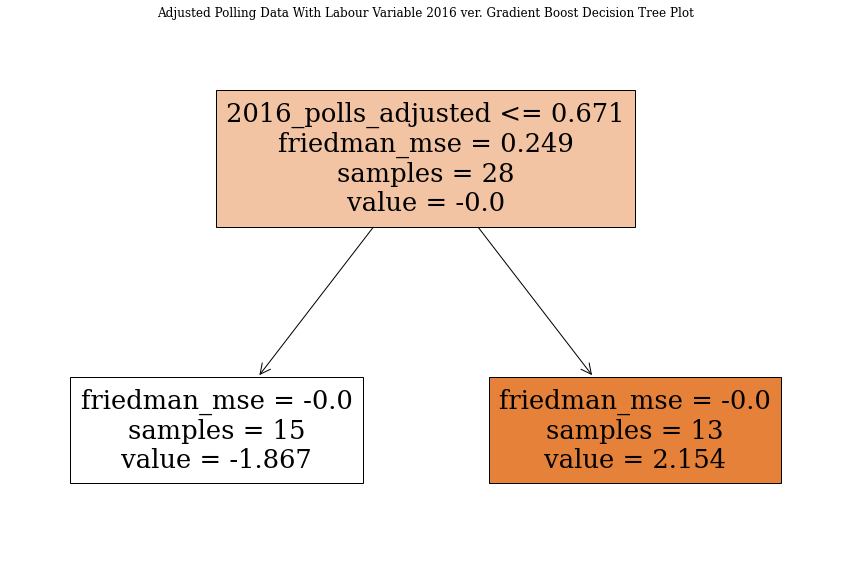

In [53]:
# we see high correlation between education and unemployment rate variable
# therefore, we need to delete either the education column or the income variable since they are too correlated for being modeled together
# we will drop education variable here
df_adjusted_exp_w_income_2016 = df_adjusted_exp_2016.drop(columns=["PercentBachelorsOrHigher", "rate",  "white_percentage"], inplace=False)

# we will make a split table not having the income level variable
df_adjusted_exp_w_education_2016 = df_adjusted_exp_2016.drop(columns=["income_per_RPPs", "rate", "white_percentage"], inplace=False)

# we will make a split table not having the income level variable
df_adjusted_exp_w_labour_2016 = df_adjusted_exp_2016.drop(columns=["PercentBachelorsOrHigher", "income_per_RPPs", "white_percentage"], inplace=False)


# add the label data at the end
df_adjusted_w_income_2016    = pd.concat([df_adjusted_exp_w_income_2016, df_result_m], axis=1)
df_adjusted_w_education_2016 = pd.concat([df_adjusted_exp_w_education_2016, df_result_m], axis=1)
df_adjusted_w_labour_2016    = pd.concat([df_adjusted_exp_w_labour_2016, df_result_m], axis=1)

# get the results for both our explanatory variables
adjusted_w_income_2016_res    = scikit_learn_accuracy_comparison(df_adjusted_w_income_2016, tossup_state_2016, "Adjusted Polling Data With Income Variable 2016 ver.", True)
adjusted_w_education_2016_res = scikit_learn_accuracy_comparison(df_adjusted_w_education_2016, tossup_state_2016, "Adjusted Polling Data With Education Variable 2016 ver.", True)
adjusted_w_labour_2016_res    = scikit_learn_accuracy_comparison(df_adjusted_w_labour_2016, tossup_state_2016, "Adjusted Polling Data With Labour Variable 2016 ver.", True)

In [ ]:
scikit_learn_accuracy_comparison(tossup_2016)